In [8]:
# Make few-shot samples for SIB-200 dataset to select n samples for each category
import os
import pandas as pd

n = 5  # Number of samples to select for each category
# Data directory containing multiple subdirectories with test.tsv files
data_directory = "sib-200/data/annotated"

# Output directory for saving few-shot samples
output_directory = f"few-shot/sib-200/train-samples/{n}-shot"

# Create the output directory if it doesn't exist
os.makedirs(output_directory, exist_ok=True)

# Iterate through subdirectories in the data directory
for language in os.listdir(data_directory):
    subdir = os.path.join(data_directory, language)
    for file in os.listdir(subdir):
        # Check if the file is a test.tsv file
        if file.endswith("train.tsv"):
            file_path = os.path.join(subdir, file)

            # Read the test.tsv file into a DataFrame
            df = pd.read_csv(file_path, sep='\t')

            # Group the DataFrame by category and select the same index for each category
            few_shot_df = df.groupby('category').apply(lambda x: x.iloc[:n]).reset_index(drop=True)

            # Save the few-shot samples to a new CSV file in the output directory
            few_shot_file_path = os.path.join(output_directory, f'{language}.csv')
            few_shot_df.to_csv(few_shot_file_path, index=False)

In [1]:
# Few-Shot learning for SIB-200 dataset by using top logprobs
# 57, 130, 150
import numpy as np
np.random.seed(42)

import os
import pandas as pd
import torch
import torch.nn.functional as F
from transformers import XGLMTokenizer, XGLMForCausalLM
from transformers import BloomForCausalLM, BloomTokenizerFast
import warnings
from tqdm import tqdm

n = 2  # Number of samples to select for each category

# Create a list of 204 shuffled arrays
random_array = np.array([np.random.permutation(np.arange(n * 7)) for _ in range(204)])

for model_address in ["bigscience/bloom-560M", "bigscience/bloom-1b1", "bigscience/bloom-1b7", "bigscience/bloom-3b"]:
    # Filter out FutureWarning messages
    warnings.simplefilter(action='ignore', category=FutureWarning)
    
    # Assuming data directory contains multiple subdirectories with test.tsv files
    data_directory = "sib-200/data/annotated"
    
    if model_address.startswith("facebook"):
        # Load learning model and tokenizer
        model = XGLMForCausalLM.from_pretrained(model_address)
        tokenizer = XGLMTokenizer.from_pretrained(model_address)
    if model_address.startswith("bigscience"):
        # Load learning model and tokenizer
        model = BloomForCausalLM.from_pretrained(model_address)
        tokenizer = BloomTokenizerFast.from_pretrained(model_address)
    
    # Move model to GPU if available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    def get_logprobs(prompt):
        inputs = tokenizer(prompt, return_tensors="pt").to(device)
        input_ids, output_ids = inputs["input_ids"], inputs["input_ids"][:, 1:]
        outputs = model(**inputs, labels=input_ids)
        logits = outputs.logits
        logprobs = torch.gather(F.log_softmax(logits, dim=2), 2, output_ids.unsqueeze(2))
        return logprobs
    
    def logprobs_prediction(prompt, alternatives, few_shots):
        few_shots_prompt = '\n'.join(few_shots.apply(lambda row: f"{row['text']}\n {row['category']}", axis=1))
        lprobs = [get_logprobs(few_shots_prompt + "\n" + prompt  + "\n " + alt).sum() for alt in alternatives]
        return alternatives[lprobs.index(max(lprobs))], max(lprobs)
    
    alternatives = ["science", "travel", "politics", "sports", "health", "entertainment", "geography"]
    
    # Output directory for saving DataFrames
    output_directory = f"few-shot/sib-200/{n}-shot/" + model_address[model_address.find('/')+1:] + "/top_logprobs"
    
    # Create the output directory if it doesn't exist
    os.makedirs(output_directory, exist_ok=True)
    
    # Iterate through subdirectories in the data directory
    for language in tqdm(os.listdir(data_directory)[150:], total=len(os.listdir(data_directory)[150:]), desc="Languages"):
        # Initialize an empty DataFrame to store results
        results_df = pd.DataFrame(columns=['text', 'actual_category', 'predicted_category'])
    
        subdir = os.path.join(data_directory, language)
        # Read the test.tsv file into a DataFrame
        file_path = os.path.join(subdir, "test.tsv")
        df = pd.read_csv(file_path, sep='\t')
    
        # Read few-shot samples into a DataFrame
        few_shot_df = pd.read_csv(os.path.join(f"few-shot/sib-200/train-samples/{n}-shot", f'{language}.csv'))
        few_shot_df['category'] = few_shot_df['category'].replace('science/technology', 'science')
    
        # Iterate through rows and compare predicted category with actual category
        for index, row in df.iterrows():
            text = row['text']
            actual_category = row['category']
    
            # Predict category
            with torch.no_grad():  # Disable gradient calculation
                predicted_category, lprob = logprobs_prediction(text, alternatives, few_shot_df.loc[random_array[index]])
    
            # Append the results to the DataFrame
            results_df = results_df.append({'text': text,
                                            'actual_category': actual_category,
                                            'predicted_category': 'science/technology' if predicted_category == 'science' else predicted_category,
                                            'logprob' : lprob.to('cpu').item()}, ignore_index=True)
            torch.cuda.empty_cache()
        # Save the results DataFrame to a CSV file in the output directory
        results_file_path = os.path.join(output_directory, f'{language}.csv')
        results_df.to_csv(results_file_path, index=False)
    del model
    torch.cuda.empty_cache()

Languages:   0%|          | 0/54 [09:33<?, ?it/s]


KeyboardInterrupt: 

In [2]:
import pandas as pd
from sklearn.metrics import f1_score

# Read the Excel file into a DataFrame
df = pd.read_excel("SIB-200 languages - ACL.xlsx")

# Calculte F1 score for each language and add it to the DataFrame
def calculate_f1(language, model, method, n):
    # Read the CSV file into a DataFrame
    try:
        results_df = pd.read_csv(f"few-shot/sib-200/{n}-shot/{model}/{method}/{language}.csv")
    except FileNotFoundError:
        return

    # Replace NaN values with 'N/A'
    results_df = results_df.fillna('N/A')

    # Calculate the F1 score
    f1 = f1_score(results_df['actual_category'], results_df['predicted_category'], average='macro')

    # Add the F1 score to the DataFrame
    df.loc[df['Folder Name'] == language, f'F1 {model} {method} {n}-shot'] = f1

# Iterate through languages and calculate F1 score for each language
for language in df['Folder Name']:
    calculate_f1(language, "bloom-560M", "top_logprobs", 2)
    calculate_f1(language, "bloom-1b1", "top_logprobs", 2)
    calculate_f1(language, "bloom-1b7", "top_logprobs", 2)
    calculate_f1(language, "bloom-3b", "top_logprobs", 2)
    calculate_f1(language, "bloom-7b1", "top_logprobs", 2)
    calculate_f1(language, "bloom-560M", "top_logprobs", 5)
    calculate_f1(language, "bloom-1b1", "top_logprobs", 5)
    calculate_f1(language, "bloom-1b7", "top_logprobs", 5)
    calculate_f1(language, "bloom-3b", "top_logprobs", 5)
    calculate_f1(language, "bloom-7b1", "top_logprobs", 5)

# Save the updated DataFrame to the Excel file
df.to_excel("SIB-200 languages - ACL.xlsx", index=False)

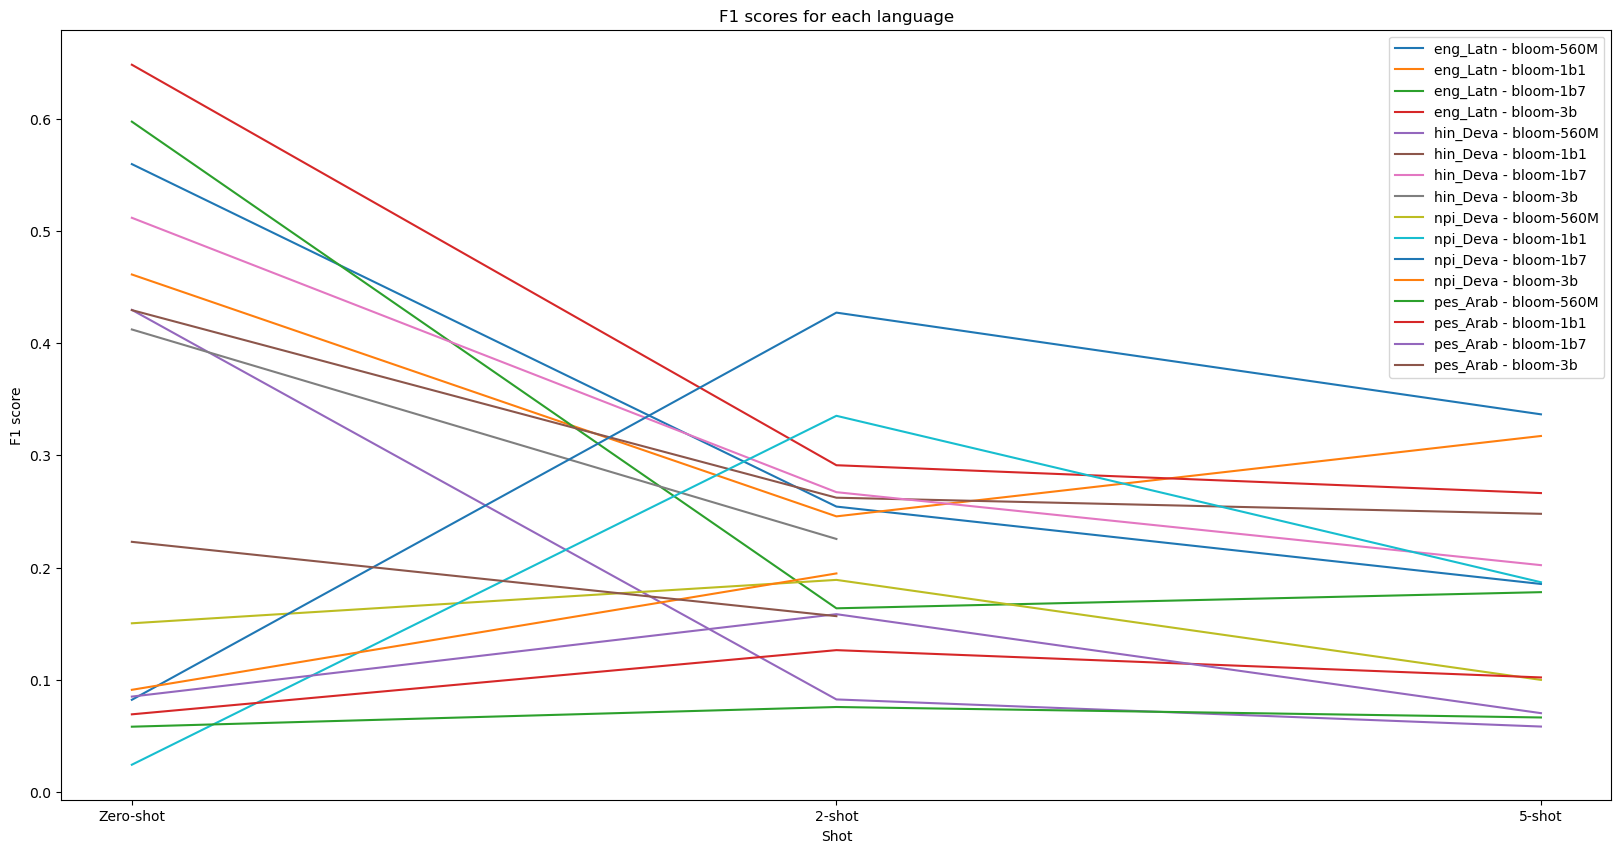

In [10]:
import matplotlib.pyplot as plt
import pandas as pd

# Read the Excel file into a DataFrame
df = pd.read_excel("SIB-200 languages - ACL.xlsx")
filtered_df = df[df['Folder Name'].isin(['eng_Latn', 'pes_Arab', 'hin_Deva', 'npi_Deva'])]

# Create a line plot of the F1 scores
plt.figure(figsize=(20, 10))
for language in filtered_df['Folder Name']:
    plt.plot(['Zero-shot', '2-shot', '5-shot'],
             [filtered_df.loc[filtered_df['Folder Name']==language, 'F1 bloom-560M top_logprobs'].values[0],
              filtered_df.loc[filtered_df['Folder Name']==language, 'F1 bloom-560M top_logprobs 2-shot'].values[0],
              filtered_df.loc[filtered_df['Folder Name']==language, 'F1 bloom-560M top_logprobs 5-shot'].values[0]],
             label=f'{language} - bloom-560M')

    plt.plot(['Zero-shot', '2-shot', '5-shot'],
             [filtered_df.loc[filtered_df['Folder Name']==language, 'F1 bloom-1b1 top_logprobs'].values[0],
              filtered_df.loc[filtered_df['Folder Name']==language, 'F1 bloom-1b1 top_logprobs 2-shot'].values[0],
              filtered_df.loc[filtered_df['Folder Name']==language, 'F1 bloom-1b1 top_logprobs 5-shot'].values[0]],
             label=f'{language} - bloom-1b1')

    plt.plot(['Zero-shot', '2-shot', '5-shot'],
             [filtered_df.loc[filtered_df['Folder Name']==language, 'F1 bloom-1b7 top_logprobs'].values[0],
              filtered_df.loc[filtered_df['Folder Name']==language, 'F1 bloom-1b7 top_logprobs 2-shot'].values[0],
              filtered_df.loc[filtered_df['Folder Name']==language, 'F1 bloom-1b7 top_logprobs 5-shot'].values[0]],
             label=f'{language} - bloom-1b7')

    plt.plot(['Zero-shot', '2-shot', '5-shot'],
             [filtered_df.loc[filtered_df['Folder Name']==language, 'F1 bloom-3b top_logprobs'].values[0],
              filtered_df.loc[filtered_df['Folder Name']==language, 'F1 bloom-3b top_logprobs 2-shot'].values[0],
              filtered_df.loc[filtered_df['Folder Name']==language, 'F1 bloom-3b top_logprobs 5-shot'].values[0]],
             label=f'{language} - bloom-3b')

plt.title('F1 scores for each language')
plt.xlabel('Shot')
plt.ylabel('F1 score')
plt.legend()
plt.show()


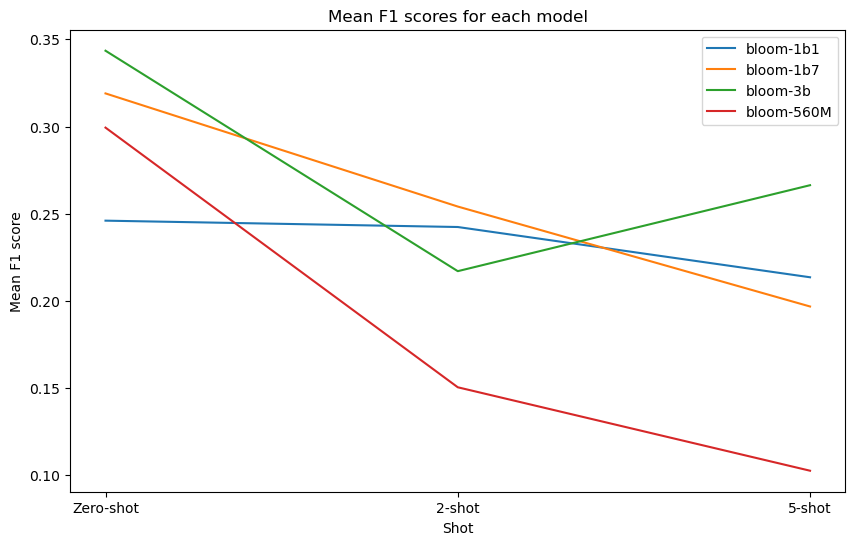

In [4]:
import matplotlib.pyplot as plt
import pandas as pd

# Read the Excel file into a DataFrame
df = pd.read_excel("SIB-200 languages - ACL.xlsx")
filtered_df = df[df['Folder Name'].isin(['eng_Latn', 'pes_Arab', 'hin_Deva', 'npi_Deva'])]

# Initialize an empty DataFrame to store reshaped data
reshaped_df = pd.DataFrame()

# Reshape the DataFrame so that each row corresponds to a model
for model in ['bloom-560M', 'bloom-1b1', 'bloom-1b7', 'bloom-3b']:
    model_data = filtered_df[filtered_df.columns[pd.Series(filtered_df.columns).str.startswith(f'F1 {model} top_logprobs')]].copy()
    model_data.columns = ['Zero-shot', '2-shot', '5-shot']
    model_data.loc[:, 'Model'] = model  # Using .loc to assign values
    reshaped_df = pd.concat([reshaped_df, model_data], ignore_index=True)

# Group by the 'Model' column and calculate the mean F1 scores for each shot
grouped_df = reshaped_df.groupby('Model').mean()

# Create a line plot of the mean F1 scores for each model
plt.figure(figsize=(10, 6))
for model in grouped_df.index:
    plt.plot(['Zero-shot', '2-shot', '5-shot'],
             grouped_df.loc[model].values,
             label=f'{model}')

plt.title('Mean F1 scores for each model')
plt.xlabel('Shot')
plt.ylabel('Mean F1 score')
plt.legend()
plt.show()


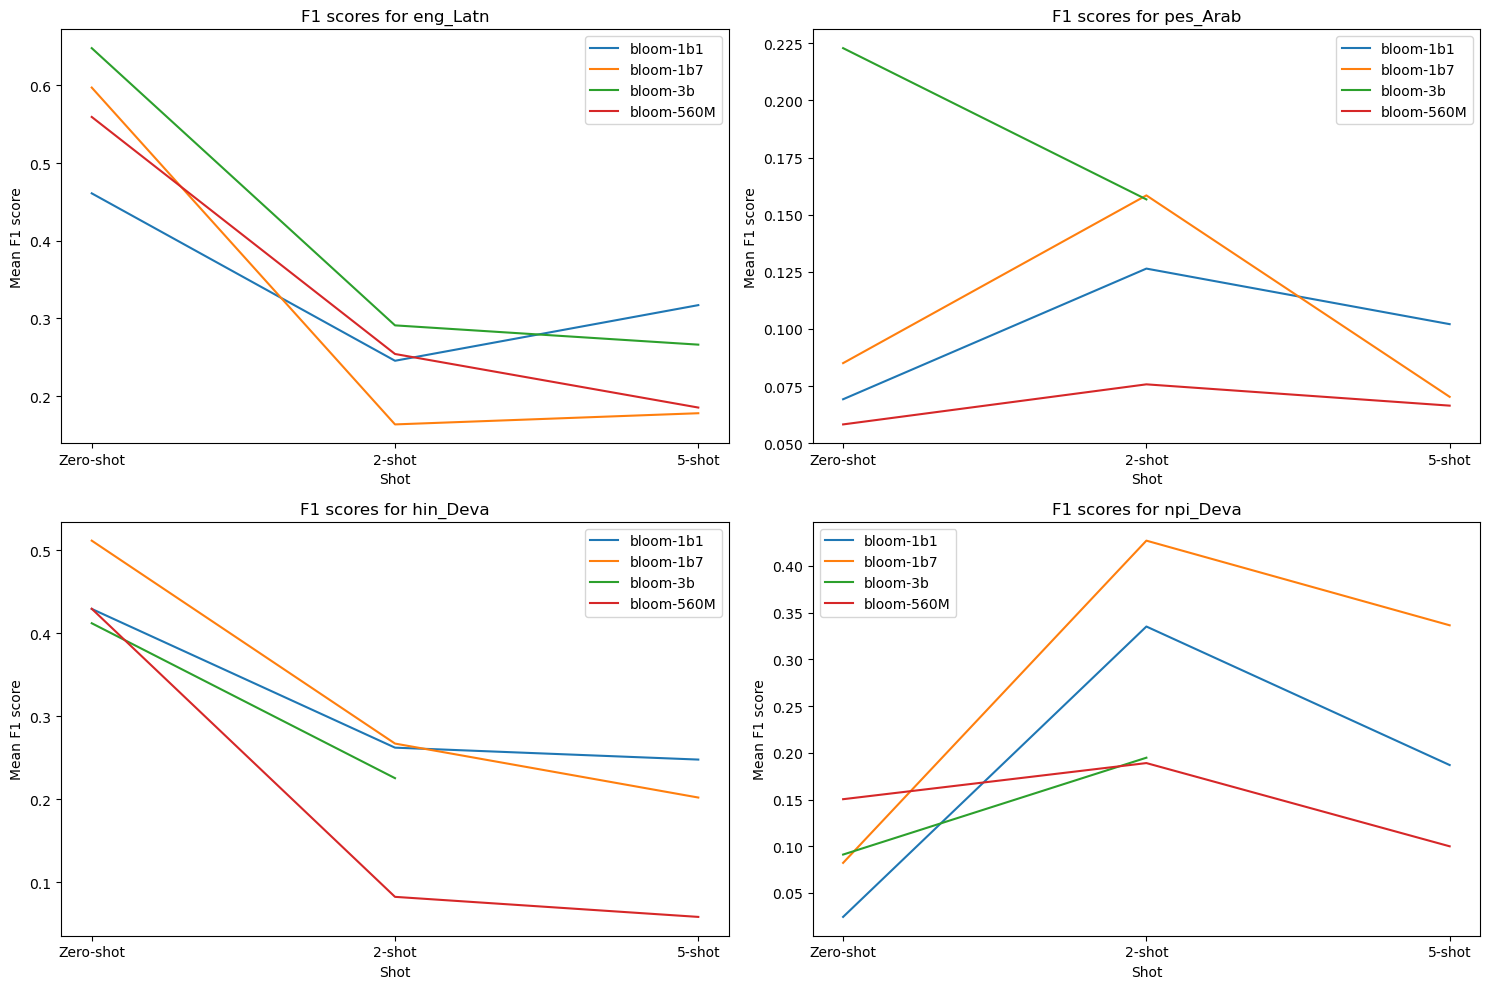

In [6]:
import matplotlib.pyplot as plt
import pandas as pd

# Read the Excel file into a DataFrame
df = pd.read_excel("SIB-200 languages - ACL.xlsx")
languages = ['eng_Latn', 'pes_Arab', 'hin_Deva', 'npi_Deva']

# Create subplots for each language
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
axes = axes.flatten()  # Flatten the 2D array of axes for easier iteration

for idx, language in enumerate(languages):
    # Filter the DataFrame for the current language
    filtered_df = df[df['Folder Name'] == language]

    # Initialize an empty DataFrame to store reshaped data
    reshaped_df = pd.DataFrame()

    # Reshape the DataFrame so that each row corresponds to a model
    for model in ['bloom-560M', 'bloom-1b1', 'bloom-1b7', 'bloom-3b']:
        model_data = filtered_df[filtered_df.columns[pd.Series(filtered_df.columns).str.startswith(f'F1 {model} top_logprobs')]].copy()
        model_data.columns = ['Zero-shot', '2-shot', '5-shot']
        model_data.loc[:, 'Model'] = model  # Using .loc to assign values
        reshaped_df = pd.concat([reshaped_df, model_data], ignore_index=True)

    # Group by the 'Model' column and calculate the mean F1 scores for each shot
    grouped_df = reshaped_df.groupby('Model').mean()

    # Plot the mean F1 scores for each model
    for model in grouped_df.index:
        axes[idx].plot(['Zero-shot', '2-shot', '5-shot'],
                       grouped_df.loc[model].values,
                       label=f'{model}')
    axes[idx].set_title(f'F1 scores for {language}')
    axes[idx].set_xlabel('Shot')
    axes[idx].set_ylabel('Mean F1 score')
    axes[idx].legend()

# Adjust layout to prevent overlap of subplots
plt.tight_layout()
plt.show()
